In [ ]:
#Libraries
using Gen
using PyPlot 
using Distributions
using LinearAlgebra
using Flux
using Random
using Distances
include("hmc_mod.jl")
include("helper_functions.jl")
include("rj_proposals_nodes.jl")
include("NUTS.jl");

In [307]:
#------------------------------------
#Hyperparameters and Helper Functions
#------------------------------------

#Select Network Goal
network = "classifier"
#network = "interpolator"

#Data hyperparameters
n = 20 #Number of samples per mode (classifier)
m = 4 #Number of modes (classifier)
d = 2 #Input dimension
N = n*m #Total samples
σₐ = 0.03 #Mode variance (classifier)
bound = 0.5

#Network hyperparameters

#Node hyperparameters
k_range = 12 #Maximum number of neurons per layer
k_list = [Int(i) for i in 1:k_range]
k_real = 2

#NUTS
Δmax = 1000;

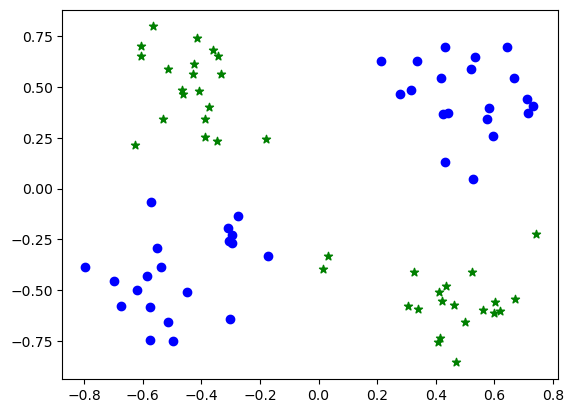

Transpose{Float64,Array{Float64,2}}

In [308]:
#Data
x_raw, classes = real_data_classifier(Int(N/4), 4, bound, σₐ);
classes = [(i+1) % 2 + 1 for i in classes]
y_real = classes

plot_data_classifier(x_raw,classes)
x = transpose(x_raw)
size(x)
typeof(x)

In [309]:
#Bayesian Neural Net
function G(x, trace)
    activation = σ
    layers = 1 #trace[:l]
    ks = [trace[(:k,i)] for i=1:layers]
    for i=1:layers
        in_dim, out_dim = layer_unpacker(i, layers, ks)
        W = reshape(trace[(:W,i)], out_dim, in_dim)
        b = reshape(trace[(:b,i)], trace[(:k,i)])
        nn = Dense(W, b, activation)
        x = nn(x)
    end
    
    Wₒ = reshape(trace[(:W,layers+1)], 1, ks[layers])
    bₒ = reshape(trace[(:b,layers+1)], 1)
    
    nn_out = Dense(Wₒ, bₒ)
    return nn_out(x)
end;

@gen function classifier(x)
    
    #Create a blank choicemap
    obs = choicemap()::ChoiceMap
    
    #Draw number of layers
    l = 1
    
    #Create individual weight and bias vectors
    #Loop through hidden layers
    k = [Int(0) for i=1:l+1]
    for i=1:l
        k[i] = @trace(categorical([1/length(k_list) for i=1:length(k_list)]), (:k,i))
        obs[(:k,i)] = k[i]
    end
    k[l+1] = @trace(categorical([1.0]), (:k,l+1))
    obs[(:k,l+1)] = k[l+1]
    
    ######################################
    #New hyperparameter schedule - Jan 20#
    ######################################
    
    #Standard Deviations
    τ₁ ~ gamma(100,0.001) #Hidden weights and biases
    τ₂ ~ gamma(100*k[1],0.001) #Output weights and biases
    σ₁ = 1/τ₁
    σ₂ = 1/τ₂
    
    #Sample weight and parameter vectors
    W = [zeros(k[i]) for i=1:l+1]
    b = [zeros(k[i]) for i=1:l+1]
    μ = [zeros(k[i]) for i=1:l+1]
    μb = [zeros(k[i]) for i=1:l+1]
   
     for i=1:l+1
        if i == 1
            h = Int(d * k[i])
        else
            h = Int(k[i-1] * k[i])
        end

        if i<=l
            #Hidden Weights
            u = zeros(h) #Draw
            S = Diagonal([1 for i=1:length(u)])
            μ[i] = @trace(mvnormal(u,S), (:μ,i))
            Σ = Diagonal([σ₁ for i=1:length(μ[i])])
            W[i] = @trace(mvnormal(μ[i],Σ), (:W,i))
            obs[(:W,i)] = W[i]
            
            #Hidden Biases
            ub = zeros(k[i]) #Draw
            Sb = Diagonal([1 for i=1:length(ub)])    
            μb[i] = @trace(mvnormal(ub,Sb), (:μb,i))
            Σ2 = Diagonal([σ₁ for i=1:length(μb[i])])
            b[i] = @trace(mvnormal(μb[i],Σ2), (:b,i))
            obs[(:b,i)] = b[i]
        else
            #Output Weights
            u = zeros(k[l]) #Draw
            S = Diagonal([1 for i=1:length(u)])
            μ[i] = @trace(mvnormal(u,S), (:μ,i))
            Σ = Diagonal([σ₂ for i=1:length(μ[i])])
            W[i] = @trace(mvnormal(μ[i],Σ), (:W,i))
            obs[(:W,i)] = W[i]

            #Output Bias
            ub = zeros(1) #Draw
            Sb = Diagonal([1 for i=1:length(ub)])  
            μb[i] = @trace(mvnormal(ub,Sb), (:μb,i))
            Σ2 = Diagonal([σ₂ for i=1:length(μb[i])])
            b[i] = @trace(mvnormal(μb[i],Σ2), (:b,i))
            obs[(:b,i)] = b[i]
        end
    end
    
    #Return Network Scores for X
    scores = G(x,obs)
    scores = Flux.σ.(scores)
    
    #Logistic Regression Likelihood
    y = scores
    for j=1:N
        y[j] = @trace(categorical([1-scores[j],scores[j]]), (:y,j))
    end
    #y = [(@trace(categorical([1-scores[j],scores[j]]), (:y,j))) for j=1:length(scores)]

    return scores
end;
obs_master = choicemap()::ChoiceMap
for i=1:length(classes)
    obs_master[(:y,i)] = classes[i]
end
obs = obs_master;
(best_trace,) = generate(classifier, (x,), obs)

println(best_trace[:τ₁])
println(best_trace[:τ₂])

test_scores = classifier(x)
test_labels = data_labeller(test_scores)
test_acc = sum([classes[i] == test_labels[i] for i=1:length(classes)])

0.20872784503643343
1.3747868844611548


40

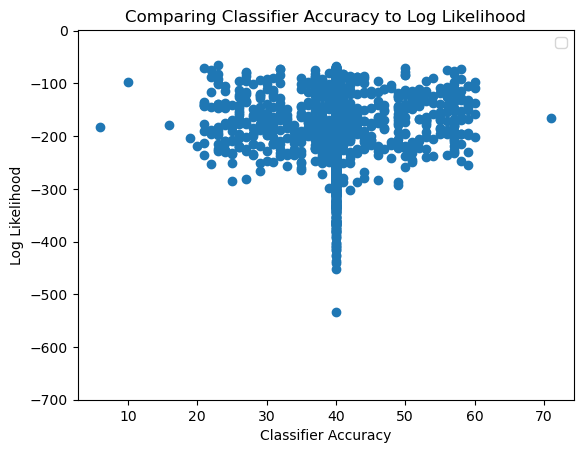

No handles with labels found to put in legend.


PyObject <matplotlib.legend.Legend object at 0x7fab794483d0>

In [310]:
#----------------
#Test Likelihood
#----------------
scores = []
accs = []
ks = []
best_ks = []
best_traces = []
(best_trace,) = generate(classifier, (x,), obs)
best_acc = 0
best_score = get_score(best_trace)
best_pred_y = (G(x, best_trace))
best_pred_labels = data_labeller(best_pred_y)
best_k = best_trace[(:k,1)]
function likelihood(best_trace, best_acc, best_score, best_k)
    obs = obs_master;
    #obs[(:k,1)] = 2
    (trace,) = generate(classifier, (x,), obs)
    
    pred_y = (G(x, trace))
    pred_labels = data_labeller(pred_y)
    acc = sum([classes[i] == pred_labels[i] for i=1:length(classes)])
    score = get_score(trace)

    if acc > best_acc
        best_acc = acc
        best_score = score
        best_trace = trace
        best_pred_y = pred_y
        best_k = best_trace[(:k,1)]
    end
    push!(best_ks,best_k)
    push!(scores,score)
    push!(accs,acc)

    return(best_trace, best_acc, best_score, best_k)
end;

for i=1:2000
    best_trace, best_acc, best_score, best_k = likelihood(best_trace, best_acc, best_score, best_k)
    push!(best_ks, best_k)
end

PyPlot.scatter(accs, scores)
plt.title("Comparing Classifier Accuracy to Log Likelihood")
plt.xlabel("Classifier Accuracy")
plt.ylabel("Log Likelihood")
plt.ylim(-700,1)
plt.legend()
#print(best_ks)

In [311]:
Random.seed!(3)

param_selection = select()
    for i=1:1+1 #Number of Layers
        #push!(param_selection, (:μ,i))
        #push!(param_selection, (:μb,i))
        push!(param_selection, (:W,i))
        push!(param_selection, (:b,i))
    end

leap = 10
ϵ = 1.4

for i=1:1000
    ϵ = i/1000 + 0.05
    (new_trace, accepted) = hmc(best_trace,param_selection,L=leap,eps=ϵ,check=false,observations=obs)
    if accepted
        println("Accepted at $ϵ")
        break
    end
end
println(best_trace[(:W,1)])
println(new_trace[(:W,1)])

println(new_trace[(:μ,1)])
trace_2 = hmc_hyperparameters2(new_trace)
println(trace_2[(:μ,1)])

Accepted at 0.052000000000000005
[0.42300134513606835, 1.7651271803076556, -0.4917088770621291, -3.4477964946236073, 1.6362991446484552, -1.6437701536013862, 0.8858027962939392, -3.348028676612685, -1.6688578405248642, 2.4562113679423008, -4.771866571596127, 0.17602973799650568, -1.8506013205673835, 0.9199248461820478, 2.377169189224256, -2.1042692197034003, 0.4807761943695854, -2.641322198764556]
[0.24108081013263838, 2.1277643872575336, -1.279115276689411, -2.7342295973468205, 1.732635565804941, -1.9407094632175432, 1.619860612769295, -3.8608544660268573, -1.9950272379654177, 2.1358580895182824, -4.1054074323201455, 0.32822574408652455, -2.184843087110825, 0.741207994708183, 2.1218350510261628, -2.4788750853016968, 0.9063093617628109, -1.8215257248935568]
[-0.3270144557794381, 1.1795681572015781, -0.48941427050907466, -1.2495134264099514, -0.21225213280092792, -0.9110907294745538, -1.275425718179521, -1.2711302052475302, 0.046646059805595275, -0.1993512527237008, -0.6316169773532655,

MethodError: MethodError: no method matching getindex(::Tuple{Gen.DynamicDSLTrace{DynamicDSLFunction{Any}},Int64}, ::Tuple{Symbol,Int64})
Closest candidates are:
  getindex(::Tuple, !Matched::Int64) at tuple.jl:24
  getindex(::Tuple, !Matched::Real) at tuple.jl:25
  getindex(::Tuple, !Matched::AbstractUnitRange{#s69} where #s69<:Real) at range.jl:290
  ...

In [ ]:
##############
#HMC SAMPLING#
##############
include("hmc_mod.jl")

Random.seed!(4)

scores = []
traces = []
ks = []
across_acceptance = []
within_acceptance = []
hyper1_acceptance = []
hyper2_acceptance = []

#HMC Hyperparameters
leap = 100
ϵ = uniform(0.02,0.03)
iters = 1

function propose_hyperparameters(trace)
    
    hyper_selection = select()
    push!(hyper_selection, :τ₁)
    push!(hyper_selection, :τ₂)
    (new_trace, weight, retdiff) = regenerate(trace, hyper_selection)
    
    if log(rand()) < weight
        return (new_trace, 1)
    else
        return (trace, 0)
    end
end;

function hmc_parameters(trace)
    
    param_selection = select()
    for i=1:1+1 #Number of Layers
        push!(param_selection, (:W,i))
        push!(param_selection, (:b,i))
    end
    
    acc = 0
    for i=1:iters
        (trace, accepted) = hmc(trace,param_selection,L=leap,eps=ϵ,check=false,observations=obs)
        if accepted
            acc = 1
        end
    end
    
    if acc == 1
        return (trace, 1)
    else
        return (trace, 0)
    end
end

function hmc_hyperparameters2(trace)
    
    hyper2_selection = select()
    for i=1:1+1 #Number of Layers
        push!(hyper2_selection, (:μ,i))
        push!(hyper2_selection, (:μb,i))
    end
    
    (trace, accepted) = hmc(trace,hyper2_selection,L=leap,eps=ϵ,check=false,observations=obs)
    
    if accepted
        return (trace, 1)
    else
        return (trace, 0)
    end
    
end

function node_parameter(trace)
    obs = obs_master
    
    prev_trace = trace
    
    hyper1_selection = select()
    push!(hyper1_selection, :τ₁)
    push!(hyper1_selection, :τ₂)
    
    hyper2_selection = select()
    for i=1:1+1 #Number of Layers
        push!(hyper2_selection, (:μ,i))
        push!(hyper2_selection, (:μb,i))
    end
    
    param_selection = select()
    for i=1:1+1 #Number of Layers
        #push!(param_selection, (:μ,i))
        #push!(param_selection, (:μb,i))
        push!(param_selection, (:W,i))
        push!(param_selection, (:b,i))
    end
    
    #################################################RJHMC#################################################
    #HMC Step 1
    trace_tilde = trace
    for i=1:iters
        (trace_tilde,) = propose_hyperparameters(trace_tilde)
        (trace_tilde,) = hmc_hyperparameters2(trace_tilde)
        (trace_tilde,) = hmc_parameters(trace_tilde)
        #(trace_tilde, accepted) = hmc(trace_tilde,param_selection,L=leap,eps=ϵ,check=false,observations=obs)
    end
    #Reversible Jump Step
    (trace_prime, q_weight) = node_change(trace_tilde)
    #HMC Step 2
    trace_star = trace_prime
    for i=1:iters
        #(trace_star, accepted) = hmc(trace_star,param_selection,L=leap,eps=ϵ,check=false,observations=obs)
        (trace_star,) = hmc_parameters(trace_star)
        (trace_star,) = hmc_hyperparameters2(trace_star)
        (trace_star,) = propose_hyperparameters(trace_star) 
    end
    #################################################RJHMC#################################################
        
    model_score = -get_score(prev_trace) + get_score(trace_star)
    across_score = model_score + q_weight
    #println(across_score)
    #println(model_score)

    if rand() < exp(across_score)
        println("Accepted: $(trace_star[(:k,1)])")
        return (trace_star, 1)
    else
        return (prev_trace, 0)
    end
end

(trace,) = generate(classifier, (x,), obs)
#trace = best_trace

for i=1:2000
    (trace, accepted) = node_parameter(trace)
    push!(across_acceptance, accepted)
    (trace, accepted)  = propose_hyperparameters(trace)
    push!(hyper1_acceptance, accepted)
    (trace, accepted)  = hmc_hyperparameters2(trace)
    push!(hyper2_acceptance, accepted)
    (trace, accepted)  = hmc_parameters(trace)
    push!(within_acceptance, accepted)
    push!(scores,get_score(trace))
    push!(traces, trace)
    push!(ks, trace[(:k,1)])
    if i%20 == 0
        a_acc = 100*(sum(across_acceptance)/length(across_acceptance))
        w_acc = 100*(sum(within_acceptance)/length(within_acceptance))
        println("Epoch $i A Acceptance Probability: $a_acc %")
        println("Epoch $i W Acceptance Probability: $w_acc %")
    end
end

In [320]:
###############
#NUTS SAMPLING#
###############

include("NUTS_CS.jl")
Random.seed!(4)

scores = []
traces = []
ks = []
across_acceptance = []
within_acceptance = []
hyper1_acceptance = []
hyper2_acceptance = []

#HMC Hyperparameters
iters = 1

function propose_hyperparameters(trace)
    
    hyper_selection = select()
    push!(hyper_selection, :τ₁)
    push!(hyper_selection, :τ₂)
    (new_trace, weight, retdiff) = regenerate(trace, hyper_selection)
    
    if log(rand()) < weight
        return (new_trace, 1)
    else
        return (trace, 0)
    end
end;

function hmc_parameters(trace)
    
    param_selection = select()
    for i=1:1+1 #Number of Layers
        push!(param_selection, (:W,i))
        push!(param_selection, (:b,i))
    end
    
    prev_score = get_score(trace)
    
    acc = 0
    for i=1:iters
        trace = NUTS(trace, param_selection, 0.65, 1, 1, false)[2]
        new_score = get_score(trace)
        if prev_score != new_score
            acc = 1
        end
    end
    
    return (trace, acc)
end

function hmc_hyperparameters2(trace)
    
    hyper2_selection = select()
    for i=1:1+1 #Number of Layers
        push!(hyper2_selection, (:μ,i))
        push!(hyper2_selection, (:μb,i))
    end
    
    prev_score = get_score(trace)
    trace = NUTS(trace, param_selection, 0.65, 1, 1, false)[2]
    new_score = get_score(trace)
    
    if prev_score != new_score
        return (trace, 1)
    else
        return (trace, 0)
    end
    
end

function node_parameter(trace)
    obs = obs_master
    
    init_trace = trace
    
    hyper1_selection = select()
    push!(hyper1_selection, :τ₁)
    push!(hyper1_selection, :τ₂)
    
    hyper2_selection = select()
    for i=1:1+1 #Number of Layers
        push!(hyper2_selection, (:μ,i))
        push!(hyper2_selection, (:μb,i))
    end
    
    param_selection = select()
    for i=1:1+1 #Number of Layers
        push!(param_selection, (:W,i))
        push!(param_selection, (:b,i))
    end
    
    #################################################RJHMC#################################################
    #HMC Step 1
    trace_tilde = trace
    for i=1:iters
        (trace_tilde,) = propose_hyperparameters(trace_tilde)
        (trace_tilde,) = hmc_hyperparameters2(trace_tilde)
        (trace_tilde,) = hmc_parameters(trace_tilde)
        #(trace_tilde, accepted) = hmc(trace_tilde,param_selection,L=leap,eps=ϵ,check=false,observations=obs)
    end
    #Reversible Jump Step
    (trace_prime, q_weight) = node_change(trace_tilde)
    #HMC Step 2
    trace_star = trace_prime
    for i=1:iters
        #(trace_star, accepted) = hmc(trace_star,param_selection,L=leap,eps=ϵ,check=false,observations=obs)
        (trace_star,) = hmc_parameters(trace_star)
        (trace_star,) = hmc_hyperparameters2(trace_star)
        (trace_star,) = propose_hyperparameters(trace_star) 
    end
    #################################################RJHMC#################################################
        
    model_score = -get_score(init_trace) + get_score(trace_star)
    across_score = model_score + q_weight
    #println(across_score)
    #println(model_score)

    if rand() < exp(across_score)
        println("Accepted: $(trace_star[(:k,1)])")
        return (trace_star, 1)
    else
        return (init_trace, 0)
    end
end

(trace,) = generate(classifier, (x,), obs)
#trace = best_trace

for i=1:2000
    (trace, accepted) = node_parameter(trace)
    push!(across_acceptance, accepted)
    (trace, accepted)  = propose_hyperparameters(trace)
    push!(hyper1_acceptance, accepted)
    (trace, accepted)  = hmc_hyperparameters2(trace)
    push!(hyper2_acceptance, accepted)
    (trace, accepted)  = hmc_parameters(trace)
    push!(within_acceptance, accepted)
    push!(scores,get_score(trace))
    push!(traces, trace)
    push!(ks, trace[(:k,1)])
    println("$i : $(get_score(trace))")
    if i%20 == 0
        a_acc = 100*(sum(across_acceptance)/length(across_acceptance))
        w_acc = 100*(sum(within_acceptance)/length(within_acceptance))
        println("Epoch $i A Acceptance Probability: $a_acc %")
        println("Epoch $i W Acceptance Probability: $w_acc %")
    end
end

Accepted: 8
1 : -157.52127285887158
Accepted: 7
2 : -143.49686642085143
3 : -143.18303758175287
Accepted: 6
4 : -125.51507757801369
5 : -126.19080584203766
Accepted: 5
6 : -114.32442441048023
7 : -117.17142800431098
8 : -117.9774853030055
Accepted: 6
9 : -126.92650730676232
Accepted: 5
10 : -108.3765946862038
11 : -110.81998326474142
Accepted: 6
12 : -127.70744623628282
Accepted: 7
13 : -140.38659849483835
14 : -140.573406280607
15 : -141.77771533327564
16 : -140.53779639288666
Accepted: 8
17 : -151.65426657627398
18 : -154.5327356864649
Accepted: 7
19 : -133.06026179007316
20 : -131.02458428547052
Epoch 20 A Acceptance Probability: 50.0 %
Epoch 20 W Acceptance Probability: 80.0 %
21 : -133.2493893940998
Accepted: 6
22 : -117.07984862595622
23 : -116.93822005384722
24 : -114.68931108545905
25 : -117.0253302931663
26 : -115.83974826959306
27 : -114.58741373452361
28 : -114.9643928993024
29 : -116.78483832836503
30 : -116.16584172736717
31 : -114.52226595714176
32 : -114.71648766263175
3

258 : -128.9588091514673
259 : -130.33208034889665
260 : -130.70633535188608
Epoch 260 A Acceptance Probability: 18.461538461538463 %
Epoch 260 W Acceptance Probability: 77.3076923076923 %
Accepted: 6
261 : -114.57516267464212
262 : -115.33704197145606
263 : -117.57979487219357
264 : -116.08167467708255
265 : -116.07273508934375
266 : -117.60504086093671
267 : -116.61868816072523
268 : -116.78234270060459
269 : -119.59371102831126
270 : -119.86765188151192
271 : -123.80627194466253
Accepted: 7
272 : -139.74327057618257
273 : -143.92052834305778
274 : -143.42945693313652
275 : -143.7463189857009
276 : -143.00825334571965
Accepted: 8
277 : -153.58280496146125
278 : -152.7646804500262
Accepted: 7
279 : -133.6564478697424
280 : -133.51531789516056
Epoch 280 A Acceptance Probability: 18.571428571428573 %
Epoch 280 W Acceptance Probability: 77.5 %
281 : -131.20236124224417
282 : -131.23711855284947
283 : -130.5024475273541
284 : -129.465938467847
285 : -130.22820994441636
286 : -128.98060547

InterruptException: InterruptException:

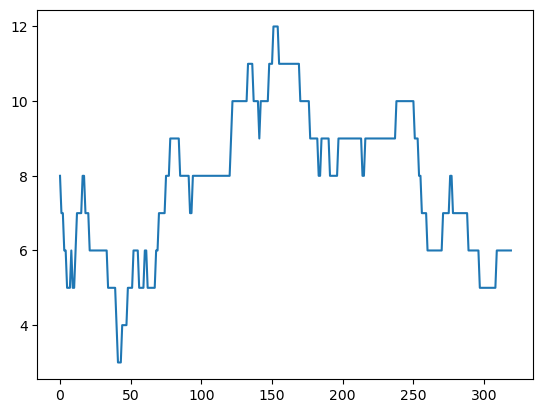

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fab7ad5ad90>

In [321]:
#-------
#K Plot
#-------
plot(ks)

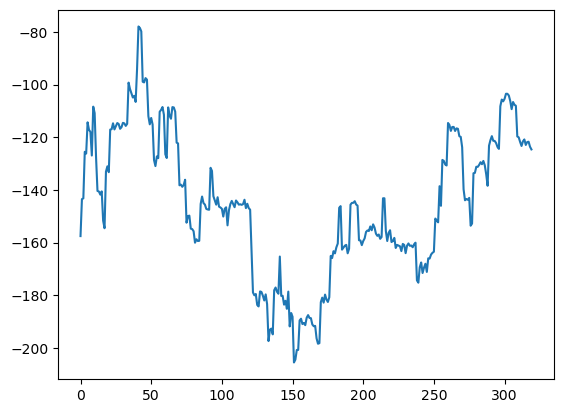

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fab7949bb10>

In [322]:
#-----------
#Score plot
#-----------

scores = [get_score(trace) for trace in traces]
plot(scores)
#plt.ylim(-200,0)

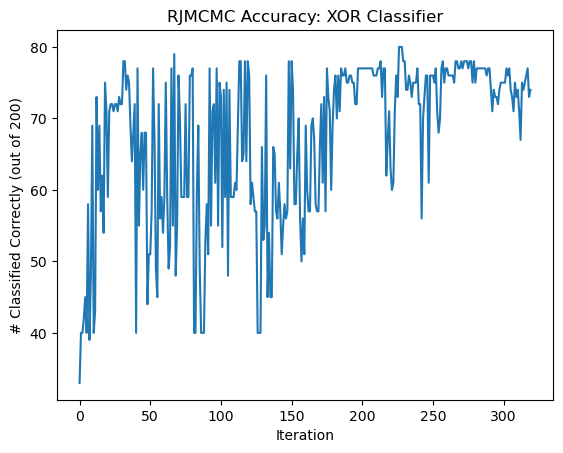

67.225


In [323]:
#---------------
#Accuracy plot
#---------------

accs = []
for i=1:length(traces)
    trace = traces[i]
    pred_y = G(x,trace)
    pred_labels = data_labeller(pred_y)
    
    acc = sum([classes[i] == pred_labels[i] for i=1:length(classes)])
    push!(accs,acc)
end

plot(accs)
println(sum(accs)/length(accs))
plt.title("RJMCMC Accuracy: XOR Classifier")
plt.xlabel("Iteration")
plt.ylabel("# Classified Correctly (out of 200)");

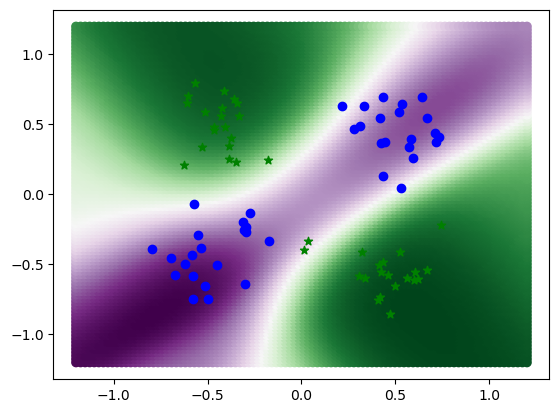

In [325]:
#---------------
#Classifier plot
#---------------

function plot_grid(data,scores,alpha=1.0)
    PyPlot.scatter(data[:,1],data[:,2],c=scores,alpha=alpha,cmap="PRGn")
    #PyPlot.colorbar()
end

function tracegrid(traces, samples=200, low=-1.2, high=1.2)
    d=2
    n=100
    r = range(low, high, length = n)
    
    iter = Iterators.product((r for _ in 1:d)...)
    grid= vec([collect(i) for i in iter])
    grid_raw = reduce(hcat, getindex.(grid,i) for i in eachindex(grid[1]))
    grid2 = transpose(grid_raw)
    z_master = zeros(length(grid2[1,:]))
    
    for i=1:samples
        j = rand((200,length(traces)))
        trace = traces[j]
        z = Flux.σ.(G(grid2,trace))[1,:]
        z_master += (z ./ samples)
    end
    plot_grid(grid_raw, z_master)
end

tracegrid(traces)
plot_data_classifier(x_raw,classes)

In [ ]:
include("NUTS_CS.jl")
Δ_max = 1000
Random.seed!(4)
(trace,) = generate(classifier, (x,), obs)

param_selection = select()
for i=1:1+1 #Number of Layers
    push!(param_selection, (:W,i))
    push!(param_selection, (:b,i))
end

traces = NUTS(trace, param_selection, 0.65, 20, 3, true)
scores = [get_score(trace) for trace in traces]

In [ ]:
θ = zeros(9)
θs = [zeros(length(θ)) for i=1:m]
θs[1] = ones(9)